In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
#load datasets
df_classes = pd.read_csv(r"C:\Users\User\Desktop\UAB\3rd year\2nd semester\synthesis project II\elliptic_bitcoin_dataset\elliptic_txs_classes.csv")
df_edges = pd.read_csv(r"C:\Users\User\Desktop\UAB\3rd year\2nd semester\synthesis project II\elliptic_bitcoin_dataset\elliptic_txs_edgelist.csv")
df_features = pd.read_csv(r"C:\Users\User\Desktop\UAB\3rd year\2nd semester\synthesis project II\elliptic_bitcoin_dataset\elliptic_txs_features.csv", header=None)

### Features characteristics
There are 166 features associated with each node. Due to intellectual property issues, we cannot provide an exact description of all the features in the dataset. There is a time step associated to each node, representing a measure of the time when a transaction was broadcasted to the Bitcoin network. The time steps, running from 1 to 49, are evenly spaced with an interval of about two weeks. Each time step contains a single connected component of transactions that appeared on the blockchain within less than three hours between each other; there are no edges connecting the different time steps.

The first 94 features represent local information about the transaction – including the time step described above, number of inputs/outputs, transaction fee, output volume and aggregated figures such as average BTC received (spent) by the inputs/outputs and average number of incoming (outgoing) transactions associated with the inputs/outputs. The remaining 72 features are aggregated features, obtained using transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and correlation coefficients of the neighbour transactions for the same information data (number of inputs/outputs, transaction fee, etc.).

In [3]:
#change column names to specify if it is a local feature or it is an aggregated one
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

In [4]:
df_features = df_features.rename(columns=colNames)
df_features.head()

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


### Nodes and edges
The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.

In [20]:
classes_count = df_classes['class'].value_counts()
class_percentage = (classes_count / len(df_classes)) * 100
for clase in class_percentage.index:
    print(f"Class {clase}: {class_percentage[clase]:.6f}%\t count: {classes_count[clase]}")

Class 3: 77.148634%	 count: 157205
Class 2: 20.620899%	 count: 42019
Class 1: 2.230467%	 count: 4545


In [5]:
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


In [6]:
df_classes.head()

,txId,class
0,230425980,3
1,5530458,3
2,232022460,3
3,232438397,2
4,230460314,3


In [8]:
print(df_classes.info())
print(df_classes.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   txId    203769 non-null  int64 
 1   class   203769 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB
None
        txId class
0  230425980     3
1    5530458     3
2  232022460     3
3  232438397     2
4  230460314     3


In [9]:
print(df_edges.info())
print(df_edges.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234355 entries, 0 to 234354
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   txId1   234355 non-null  int64
 1   txId2   234355 non-null  int64
dtypes: int64(2)
memory usage: 3.6 MB
None
       txId1      txId2
0  230425980    5530458
1  232022460  232438397
2  230460314  230459870
3  230333930  230595899
4  232013274  232029206


In [15]:
df_features.columns

Index(['txId', 'Time step', 'Local_feature_1', 'Local_feature_2',
       'Local_feature_3', 'Local_feature_4', 'Local_feature_5',
       'Local_feature_6', 'Local_feature_7', 'Local_feature_8',
       ...
       'Aggregate_feature_63', 'Aggregate_feature_64', 'Aggregate_feature_65',
       'Aggregate_feature_66', 'Aggregate_feature_67', 'Aggregate_feature_68',
       'Aggregate_feature_69', 'Aggregate_feature_70', 'Aggregate_feature_71',
       'Aggregate_feature_72'],
      dtype='object', length=167)

<BarContainer object of 3 artists>

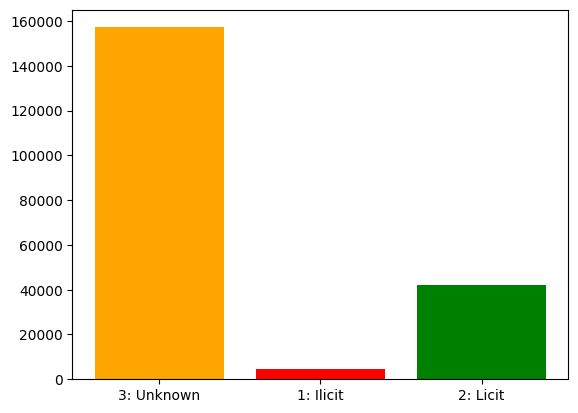

In [25]:
#distribution of classes
group_class = df_classes.groupby('class').count()
plt.bar(['3: Unknown', '1: Ilicit', '2: Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )

Text(0.5, 1.0, 'Number of transactions by Time step')

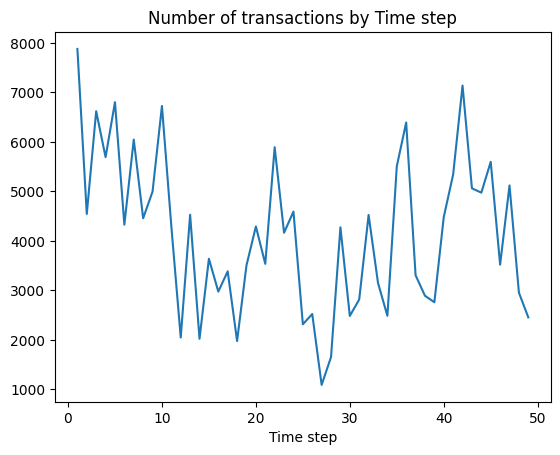

In [21]:
#transactions byt time step
group_feature = df_features.groupby('Time step').count()
group_feature['txId'].plot()
plt.title('Number of transactions by Time step')

<Axes: xlabel='Time step', ylabel='count'>

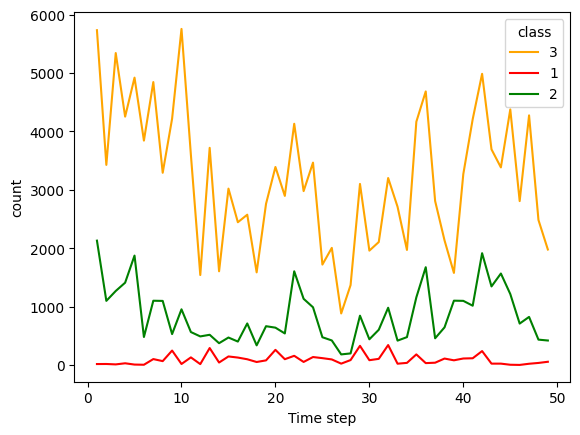

In [26]:
#merge the class and the features to plot how many transactions each class have each time step
df_class_feature = pd.merge(df_classes, df_features )
group_class_feature = df_class_feature.groupby(['Time step', 'class']).count()
#plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )
group_class_feature = group_class_feature['txId'].reset_index().rename(columns={'txId': 'count'})#unstack()
sns.lineplot(x='Time step', y='count', hue='class', data = group_class_feature, palette=['orange', 'r', 'g'] )

Text(0.5, 0, 'Time step')

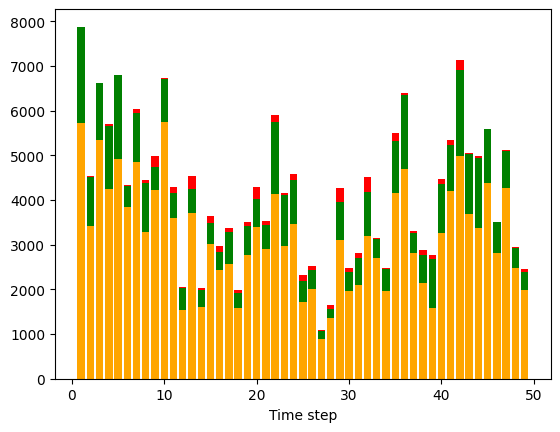

In [27]:
#barplot to compare the count of transactions of each class each time step
class1 = group_class_feature[group_class_feature['class'] == '1']
class2 = group_class_feature[group_class_feature['class'] == '2']
class3 = group_class_feature[group_class_feature['class'] == 3 ]

p1 = plt.bar(class3['Time step'], class3['count'], color = 'orange')

p2 = plt.bar(class2['Time step'], class2['count'], color='g',
             bottom=class3['count'])

p3 = plt.bar(class1['Time step'], class1['count'], color='r',
             bottom=np.array(class3['count'])+np.array(class2['count']))

plt.xlabel('Time step')
